In [14]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy 
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear
 
from qiskit import QuantumCircuit
#from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
import pylatexenc

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

import pandas as pd

torch.backends.cudnn.benchmark = True


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

directory = 'Experiments/'
experiment_id = 'EfficientSU2/ZFeatureMap/'

num_qubits = 3
num_layers = 1

features = ["SEED1", "TEAM1_ID", "DUNKS FG%1","SEED2", "TEAM2_ID", "DUNKS FG%2", "CURRENT ROUND"]
target = "WINNER"

feature_map_experiment = ZFeatureMap
#feature_map_experiment = ZZFeatureMap

#ansatz_experiment = RealAmplitudes
ansatz_experiment = EfficientSU2


cpu


QNN Training Parameters: 12
QNN Input Parameters: 3
QNN Circuit Depth: 2


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_98597/3992426414.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


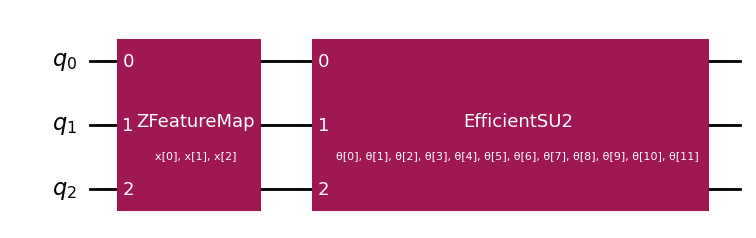

In [16]:
def create_qnn():
    qc = QuantumCircuit(num_qubits)
    feature_map = feature_map_experiment(num_qubits)
    ansatz = ansatz_experiment(num_qubits=num_qubits, reps=num_layers)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

qnn = create_qnn()

print("QNN Training Parameters:", qnn.num_weights) 
print("QNN Input Parameters:", qnn.num_inputs)
print("QNN Circuit Depth:", qnn.circuit.depth())

qnn.circuit.draw('mpl')

In [17]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.qnn = nn.Sequential(nn.LazyLinear(len(features)),
            nn.LazyLinear(qnn.num_inputs),
            nn.Tanh(),
            TorchConnector(qnn),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.qnn(x)
        return x

In [18]:
from torch.optim.lr_scheduler import StepLR  

net = Model().to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
criterion = nn.BCELoss()
batch_size = 32
num_epochs = 2500

net.to(device)
net.train()

Model(
  (qnn): Sequential(
    (0): LazyLinear(in_features=0, out_features=7, bias=True)
    (1): LazyLinear(in_features=0, out_features=3, bias=True)
    (2): Tanh()
    (3): TorchConnector()
    (4): LazyLinear(in_features=0, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [19]:
# Load data
import pandas as pd

df = pd.read_csv("Games.csv")

df['TEAM1_ID'] = df['TEAM1_ID'].fillna(-1)
df['TEAM2_ID'] = df['TEAM2_ID'].fillna(-1)



df = df.fillna(0)

team_id_name_dict = {}

for _, row in df.iterrows():
    key1 = row['TEAM1_ID']
    value1 = row['TEAM1']

    key2 = row['TEAM2_ID']
    value2 =  row['TEAM2']

    team_id_name_dict[key1] = value1
    team_id_name_dict[key2] = value2

test_years = [2013 ,2018, 2025]
              
test_df = df[df["YEAR"].isin(test_years)]
test_df = test_df.drop_duplicates(subset=['YEAR', 'TEAM1', 'CURRENT ROUND'])
test_df = test_df.dropna(subset=['WINNER'])

train_val_df = df[~df["YEAR"].isin(test_years)]

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)


In [20]:

print(test_df['YEAR'].unique())
print(train_df['YEAR'].unique())


[2025 2018 2013]
[2021 2017 2014 2019 2009 2016 2015 2010 2011 2008 2012 2024 2022 2023]


In [21]:
from torch.utils.data import TensorDataset, DataLoader

def to_tensor(df):
    X = torch.tensor(df[features].values, dtype=torch.float32)
    y = torch.tensor(df[target].values, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(X, y)

In [22]:
train_dataset = to_tensor(train_df)
val_dataset = to_tensor(val_df)


In [23]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [24]:
def plot_loss(train, val):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.legend()
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.savefig(directory + experiment_id+  'loss.png')
    plt.show()
    
def plot_accuracy(train, val):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(directory + experiment_id+ 'accuracy.png')
    plt.show()
 

In [25]:
def calc_val_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            predicted = (outputs > 0.5).float()

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    return correct / total

def calc_val_loss(loader):
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(loader)

def calc_train_accuracy(X, y):
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = net(X)
        predicted = (outputs > 0.5).float()

        total += y.size(0)

        correct += (predicted == y).sum().item()
    return correct / total

In [ ]:
# Initialize lists to store losses and accuracies
losses = []
val_losses = []

best_loss = float('inf')
best_accuracy = 0.0

loss_epoch = 0
accuracy_epoch = 0

train_accuracys = []
val_accuracys = []

# Training loop
for epoch in range(num_epochs+1):
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for X_batch, y_batch in train_loader:
    
        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        preds = net(X_batch)

        if preds.shape != y_batch.shape:
            y_batch = y_batch.view(preds.shape)
      
        # Calculate loss
        loss = criterion(preds, y_batch.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_accuracy += calc_train_accuracy(X_batch, y_batch)
        epoch_loss += loss.item()
  
    val_loss = calc_val_loss(val_loader)
    val_accuracy = calc_val_accuracy(val_loader)

    losses.append(epoch_loss / len(train_loader))
    train_accuracys.append(epoch_accuracy / len(train_loader))

    val_accuracys.append(val_accuracy)
    val_losses.append(val_loss)
        
    clear_output(wait=True)
    print(f"Epoch [{epoch}/{num_epochs}]\n")
    print(f"Train Loss: {epoch_loss / len(train_loader):.4f}")
    print(f"Validation Loss: {val_loss:.4f}\n")
    print(f"Train Accuracy: {epoch_accuracy / len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f} \n")

    
    if epoch > 100:

        running_loss = np.mean(val_losses[-50:])
        running_accuracy = np.mean(val_accuracys[-50:])

        if running_loss < best_loss:
            best_loss = running_loss
            loss_epoch = epoch
            torch.save(net.state_dict(), directory + experiment_id + 'best_lost_model.pth')
            
        if running_accuracy > best_accuracy:
            best_accuracy = running_accuracy
            accuracy_epoch = epoch
            torch.save(net.state_dict(), directory + experiment_id + 'best_accuracy_model.pth')
        
    if epoch % 50 == 0:
        plot_loss(losses, val_losses)
        plot_accuracy(train_accuracys, val_accuracys)
        print(f"Model saved at epoch {loss_epoch} with loss {best_loss:.4f}")
        print(f"Model saved at epoch {accuracy_epoch} with accuracy {best_accuracy:.4f}")


torch.save(net.state_dict(), directory + experiment_id + 'final_model.pth')
        

Epoch [1410/2500]

Train Loss: 0.6222
Validation Loss: 0.6170

Train Accuracy: 0.6207
Validation Accuracy: 0.6328 



In [ ]:
# Load the best model
best_model = Model().to(device)
best_model.load_state_dict(torch.load(directory + "Initial/"+ 'best_accuracy_model.pth'))
best_model.eval()

test_dict = {}



team1_features = ["SEED1",  "TEAM1_ID", "DUNKS FG%1"]
team2_features = ["SEED2", "TEAM2_ID", "DUNKS FG%2"]

for year in test_years:
    print(f"Testing year: {year}")
    test_year_df = test_df[test_df["YEAR"] == year]
    test_year_df = test_year_df[test_year_df["CURRENT ROUND"] == 64]

    team1_X = torch.tensor(test_year_df[team1_features].values, dtype=torch.float32)
    team2_X = torch.tensor(test_year_df[team2_features].values, dtype=torch.float32)

    y = torch.tensor(test_year_df[target].values, dtype=torch.float32).unsqueeze(1)

    test_dict[year] = {}
    test_dict[year]['team1'] = team1_X
    test_dict[year]['team2'] = team2_X
    test_dict[year]['y'] = y

round_winner_dict = {}

for year in [2013, 2018]:
    
    test_year_df = test_df[test_df["YEAR"] == year]

    round_winner_dict[year] = {64:[], 32:[], 16:[], 8:[], 4:[], 2:[]}
    
    for _, row in test_year_df.iterrows():

        key = row['CURRENT ROUND']

        y = row['WINNER']
        value = row['TEAM1_ID']
        if y == 1:
            value = row['TEAM2_ID']

        round_winner_dict[year][key].append(value)
 




In [43]:

round_winner_dict[2025] = {64:[41, 27, 21, 24, 0, 140, 20, 25, 31, 55, 3, 123, 30, 15, 2, 13, 36, 23, 5, 64, 16, 22, 12, 11, 8, 29, 103, 19, 9, 28, 7, 18],
                           32:[27, 55, 2, 13, 0, 20, 24, 31, 8, 16, 29, 23, 11, 12, 7, 19],
                           16:[23, 8, 16, 13, 7, 31, 0, 24],
                           8:[8, 16, 24, 0],
                           4:[8, 24],
                           2:[8]}

In [76]:
def print_team(team):
    return team_id_name_dict[team[1].item()]

def round_predict(model, temp ,year, points =0, printout=True):
    results = {}
    team_nums = int(temp['team1'].shape[0]*2)

    team1 = temp['team1']
    team2 = temp['team2']

    combined = torch.cat((team1, team2), dim=1)
    round = torch.tensor([team_nums], dtype=torch.float32).unsqueeze(1).repeat(combined.shape[0], 1)
    combined = torch.cat((combined, round), dim=1)
    combined = combined.to(device)

    current_round_points = 0
    
    results = {'team1': [], 'team2': []}
    for i in range(0,combined.shape[0], 2):
        game1 = combined[i]
        game2 = combined[i+1]

        outcome1 = model(game1)
        outcome2 = model(game2)

        winner1 =0
        winner2 = 0

        if outcome1<.5:
            winner1 = team1[i]
        else:
            winner1 = team2[i]

        if outcome2<.5:
            winner2 = team1[i+1]
        else:
            winner2 = team2[i+1]

        results['team1'].append(winner1)
        results['team2'].append(winner2)

        current_round_points = cbs_points(int(winner1[1].item()), team_nums, year)

        if printout:
            print( print_team(team1[i]), "vs", print_team(team2[i]), "Winner:", print_team(winner1))
            print("     Points: ", current_round_points)
        points += current_round_points

        current_round_points = cbs_points(int(winner2[1].item()), team_nums, year)
        
        if printout:
            print( print_team(team1[i+1]), "vs", print_team(team2[i+1]), "Winner:", print_team(winner2))
            print("     Points: ", current_round_points)
        points += current_round_points
            

    results['team1'] = torch.stack(results['team1'])
    results['team2'] = torch.stack(results['team2'])
    if printout:
        print("Total Points: ", points)
    return results, points

def championship(best_model,temp, year, points = 0): 
    
    team1 = temp['team1']
    team2 = temp['team2']

    round_points = 0

    combined = torch.cat((team1, team2), dim=1)
    round = torch.tensor([2], dtype=torch.float32).unsqueeze(1)
    combined = torch.cat((combined, round), dim=1)
    combined = combined.to(device)

    outcome = best_model(combined)

    winner = None
    if outcome < .5:
        winner = team1
    else:
        winner = team2
    round_points += cbs_points(winner[0][1].item(), 2, year)

    print("Championship")
    print(team_id_name_dict[team1[0][1].item()], " vs ", team_id_name_dict[team2[0][1].item()])

    print("     Winner: ", team_id_name_dict[winner[0][1].item()])
    print("     Points: ", round_points)
    points += round_points
    print("Total Points: ", points)

def tournament_predict(best_model, temp, year):

    temp = temp[year]
    round1, points1 = round_predict(best_model, temp, year, printout=False)
    round2, points2 = round_predict(best_model, round1, year,  points= points1, printout=False)
    round3, points3 = round_predict(best_model, round2, year, points= points2, printout= False)
    print("Elite 8")
    round4, points4 = round_predict(best_model, round3, year, points= points3)
    print("\nFinal Four")
    round5, points5 = round_predict(best_model,round4, year, points= points4)
    print("\n")
    championship(best_model, round5, year, points= points5)

def cbs_points(winner, round, year):
    round_winners = round_winner_dict[year][round]
    if winner in round_winners:
        return 32 / (round//2)
    else:
        return 0




In [ ]:
year = 2018
print("Year: ", year, '\n')
temp= test_dict
tournament_predict(best_model, temp, year)

In [ ]:
year = 2013
print("Year: ", year, '\n')
temp= test_dict
tournament_predict(best_model, temp, year)

In [ ]:
year = 2025
print("Year: ", year, '\n')
temp= test_dict
tournament_predict(best_model, temp, year)